In [ ]:
from google.cloud import bigquery
from google.colab import auth
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Packages for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model

In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project='nft-dashboard-381202')

In [ ]:
Query = f"""
    SELECT *
    FROM `nft-dashboard-381202.nfts_pipeline.nfts_pipeline_collection_Cryptopunks`
    ORDER BY block_number ASC
"""
data = client.query(Query).to_dataframe()

In [ ]:
data.head()

,collection_address,marketplace,token_id,seller,buyer,price_currency,price,protocol_fee_currency,protocol_fee,transaction_hash,block_number
0,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,544,0xc352b534e8b987e036a93539fd6897f53488e56a,0x5b098b00621eda6a96b7a476220661ad265f083f,ETH,0.010000000,None,0.0,0xb28b5f2c186bf534e4fc4b8604b1496c9632e4226942...,3919706
1,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,3134,0x5b098b00621eda6a96b7a476220661ad265f083f,0xc352b534e8b987e036a93539fd6897f53488e56a,ETH,0.010000000,None,0.0,0x65579455ac3227e7b3db72b4e359e988bb16cae6d26c...,3919721
2,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,5056,0xc352b534e8b987e036a93539fd6897f53488e56a,0x00bd9fd57c423a1b1c969823d409156d90974d77,ETH,0.100000000,None,0.0,0xd79cca9282c06a0edb8f9426aae734119f0f2ed0d968...,3919847
3,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,5719,0x5b098b00621eda6a96b7a476220661ad265f083f,0x00bd3a6660309fb9e0129b9b777a9ccb9c2869dc,ETH,0.040000000,None,0.0,0x03c36b107006386b2db0e77667cc3fd4321d03668438...,3919887
4,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,6548,0x5b098b00621eda6a96b7a476220661ad265f083f,0x00bd3a6660309fb9e0129b9b777a9ccb9c2869dc,ETH,0.030000000,None,0.0,0x85467bb2cbbdbea4542baa0307729e8a8c1a119dcf57...,3919893


### Data Preprocessing and EDA

In [ ]:
data['price'] = data['price'].astype(float)
# Normalize input data
scaler = MinMaxScaler()
data['price'] = scaler.fit_transform(data[['price']])

# data['price_diff'] = data['price'].diff()
# data['price_pct_change'] = data['price'].pct_change()
# data = data.dropna(subset=['price_diff'])
# data = data.dropna(subset=['price_pct_change'])
# Drop non-numerical columns
# data = data.drop(['collection_address', 'marketplace', 'token_id', 'seller', 'buyer', 'price_currency', 'protocol_fee_currency', 'protocol_fee', 'transaction_hash'], axis=1)


In [ ]:
data

,collection_address,marketplace,token_id,seller,buyer,price_currency,price,protocol_fee_currency,protocol_fee,transaction_hash,block_number
0,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,544,0xc352b534e8b987e036a93539fd6897f53488e56a,0x5b098b00621eda6a96b7a476220661ad265f083f,ETH,0.000067,None,0.0,0xb28b5f2c186bf534e4fc4b8604b1496c9632e4226942...,3919706
1,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,3134,0x5b098b00621eda6a96b7a476220661ad265f083f,0xc352b534e8b987e036a93539fd6897f53488e56a,ETH,0.000067,None,0.0,0x65579455ac3227e7b3db72b4e359e988bb16cae6d26c...,3919721
2,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,5056,0xc352b534e8b987e036a93539fd6897f53488e56a,0x00bd9fd57c423a1b1c969823d409156d90974d77,ETH,0.000667,None,0.0,0xd79cca9282c06a0edb8f9426aae734119f0f2ed0d968...,3919847
3,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,5719,0x5b098b00621eda6a96b7a476220661ad265f083f,0x00bd3a6660309fb9e0129b9b777a9ccb9c2869dc,ETH,0.000267,None,0.0,0x03c36b107006386b2db0e77667cc3fd4321d03668438...,3919887
4,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,6548,0x5b098b00621eda6a96b7a476220661ad265f083f,0x00bd3a6660309fb9e0129b9b777a9ccb9c2869dc,ETH,0.000200,None,0.0,0x85467bb2cbbdbea4542baa0307729e8a8c1a119dcf57...,3919893
...,...,...,...,...,...,...,...,...,...,...,...
5988,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,3179,0x7ea6030486fabd4844785c99a13dfd66ca05b386,0x641cf19cbd83666d8e21652981db09088568528b,ETH,0.029333,None,0.0,0xd61c95603f73e7790ab5dd3ddb66788f6cc035220e84...,11505648
5989,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,3853,0x7ea6030486fabd4844785c99a13dfd66ca05b386,0x865c964edc75e0f1f5c0631ea068baac2e490e57,ETH,0.033333,None,0.0,0x2ce4d150ddfb7202575907cb2eb9617e297e8624abbc...,11505769
5990,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,3082,0x665498c14f80647d2a57a1f54eee4aaa9920fae8,0x641cf19cbd83666d8e21652981db09088568528b,ETH,0.030000,None,0.0,0x943300cfd15c7b40cf459cdc125c8fa629b03a67c8f6...,11505894
5991,0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB,cryptopunks,6160,0x219688c6156edea2e2ca7e2036c1c5b7f6451169,0xbf6ccf49cc2874f01916d747a8fe97f14a082be0,ETH,0.026600,None,0.0,0x16c2836c54d9f6b2cffc5b7d9a31d34b29ebb75f9967...,11505938


In [ ]:
data.describe()

,price,block_number
count,5993.000000,5993.0
mean,0.011466,7971058.859169
std,0.029506,2615240.663443
min,0.000000,3919706.0
25%,0.001667,5179512.0
50%,0.003667,8552860.0
75%,0.010600,10322870.0
max,1.000000,11505938.0


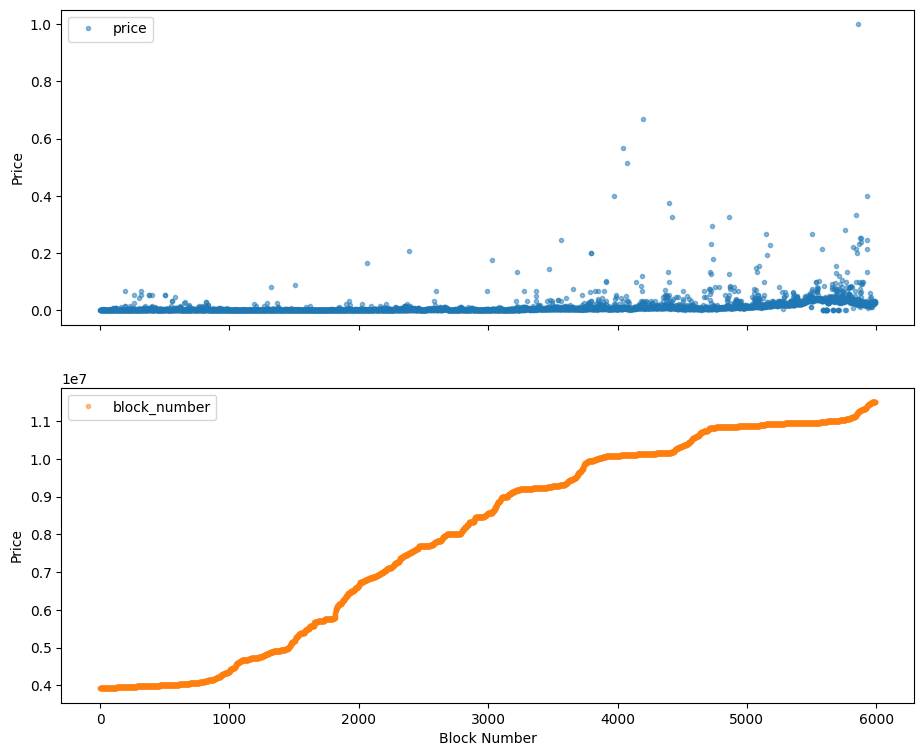

In [ ]:
cols_plot = ['price', 'block_number']
graphs = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for graph in graphs:
    graph.set_xlabel('Block Number'),
    graph.set_ylabel('Price')

In [ ]:
X = []
Y = []
window_size = 10
for i in range(1, len(data) - window_size - 1, 1):
    first = data.iloc[i, 6]  # The 'price' column index is 6
    features = []
    label = []
    eps = 1e-8 # A small constant value to avoid division by zero
    for j in range(window_size):
        rel_price = data.iloc[i + j, 6]
        features.append(rel_price)
    label.append(data.iloc[i + window_size, 6])
    X.append(np.array(features).reshape(window_size, 1))
    Y.append(np.array(label).reshape(1, 1))
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,window_size,1)
test_X = test_X.reshape(test_X.shape[0],1,window_size,1)

print(train_X.shape)
print(test_X.shape)

(4784, 1, 10, 1)
(1197, 1, 10, 1)


In [ ]:

def construct_model():
  model = tf.keras.Sequential()

  # CNN layers
  model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, window_size, 1))))
  model.add(TimeDistributed(MaxPooling1D(2)))
  model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='tanh')))
  model.add(TimeDistributed(MaxPooling1D(2)))
  # model.add(TimeDistributed(Conv1D(32, kernel_size=3, activation='relu')))
  # model.add(TimeDistributed(MaxPooling1D(2)))
  model.add(TimeDistributed(Flatten()))
  # model.add(Dense(5, kernel_regularizer=L2(0.01)))

  # LSTM layers
  model.add(Bidirectional(LSTM(50, return_sequences=True)))
  model.add(Dropout(0.5))
  # model.add(Bidirectional(LSTM(window_size, return_sequences=False)))
  # model.add(Dropout(0.5))

  #Final layers
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
  return model

# Train the model
model = construct_model()
results = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=50, batch_size=50, verbose=1, shuffle =True)

Epoch 1/50
96/96 [==============================] - 8s 19ms/step - loss: 8.7031e-04 - mse: 8.7031e-04 - mae: 0.0097 - val_loss: 4.2666e-04 - val_mse: 4.2666e-04 - val_mae: 0.0061
Epoch 2/50
96/96 [==============================] - 1s 8ms/step - loss: 8.2336e-04 - mse: 8.2336e-04 - mae: 0.0085 - val_loss: 5.0486e-04 - val_mse: 5.0486e-04 - val_mae: 0.0139
Epoch 3/50
96/96 [==============================] - 1s 10ms/step - loss: 8.5145e-04 - mse: 8.5145e-04 - mae: 0.0096 - val_loss: 4.4689e-04 - val_mse: 4.4689e-04 - val_mae: 0.0072
Epoch 4/50
96/96 [==============================] - 1s 10ms/step - loss: 8.1817e-04 - mse: 8.1817e-04 - mae: 0.0088 - val_loss: 4.4565e-04 - val_mse: 4.4565e-04 - val_mae: 0.0103
Epoch 5/50
96/96 [==============================] - 1s 9ms/step - loss: 8.0698e-04 - mse: 8.0698e-04 - mae: 0.0086 - val_loss: 4.2496e-04 - val_mse: 4.2496e-04 - val_mae: 0.0084
Epoch 6/50
96/96 [==============================] - 1s 9ms/step - loss: 8.1903e-04 - mse: 8.1903e-04 - mae:

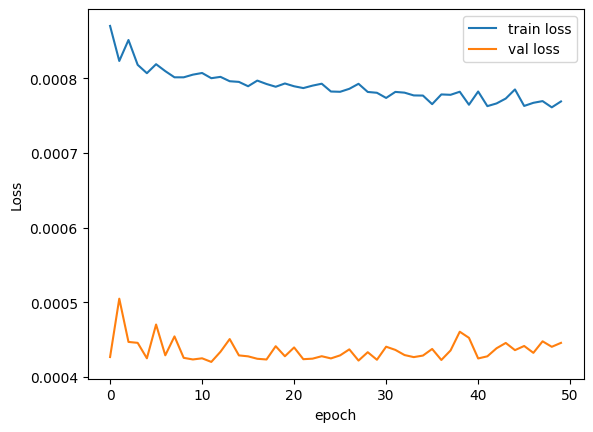

In [ ]:
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 8, 64)         256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 4, 64)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 2, 128)        24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 1, 128)        0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 128)           0

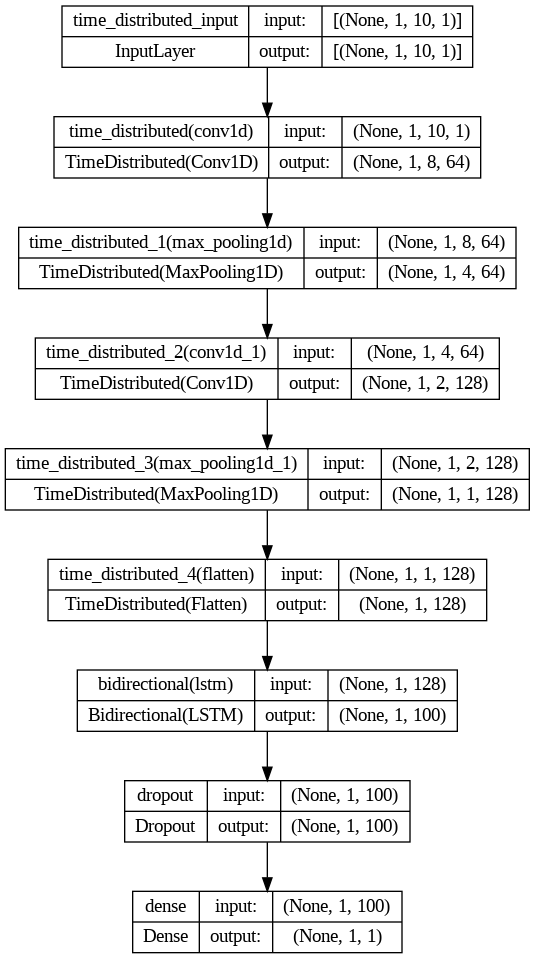

In [ ]:
# Print_the_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.evaluate(test_X, test_Y)

38/38 [==============================] - 0s 3ms/step - loss: 4.4562e-04 - mse: 4.4562e-04 - mae: 0.0072


[0.0004456228925846517, 0.0004456228925846517, 0.007169855758547783]

In [ ]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
test_label = test_Y.reshape(-1,1)
var = explained_variance_score(test_label, yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_label, yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_label, yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.221443
R2 Score: 0.221443
Max Error: 0.315774


In [ ]:
predicted  = model.predict(test_X)
predicted = np.array(predicted[:,0]).reshape(-1,1)
real_prices = deepcopy(test_label)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    # Use 'price' of NFT to predict
    temp = data.iloc[j, 6]
    real_prices[j - len_t] = real_prices[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

38/38 [==============================] - 0s 4ms/step


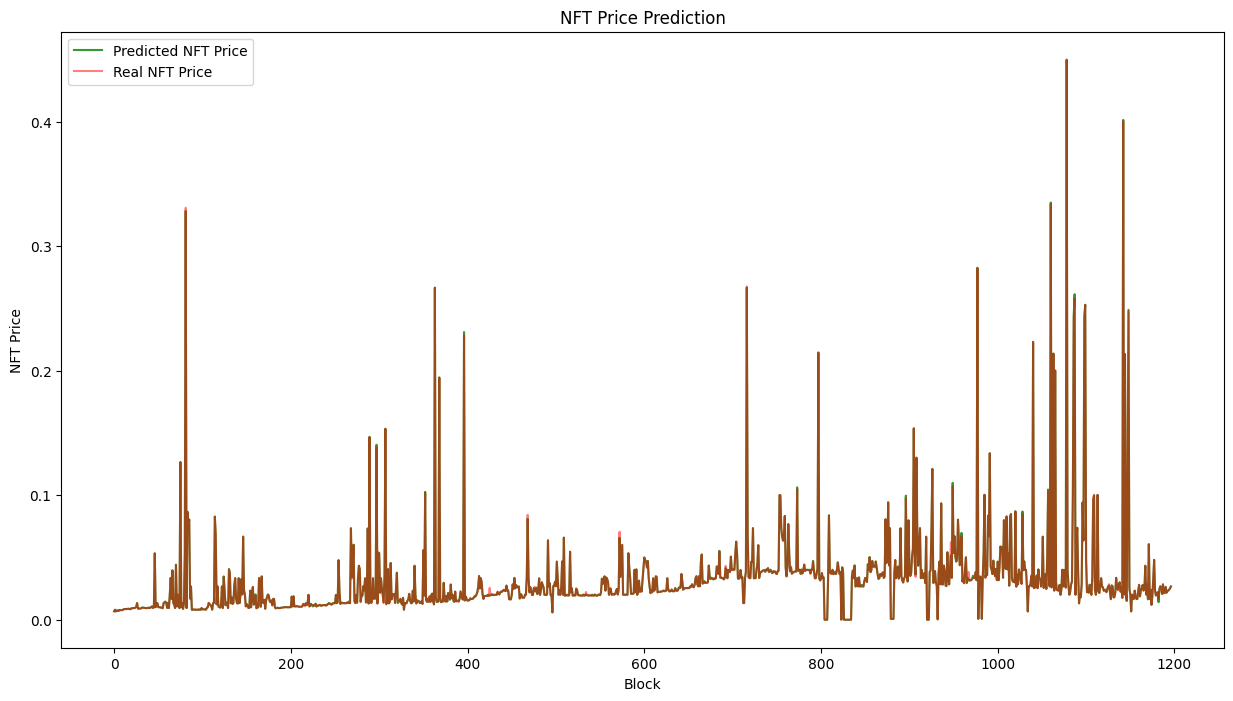

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Remove outliers by clipping the values
threshold = 0.45
predicted_clipped = np.clip(predicted, 0, threshold)
real_prices_clipped = np.clip(real_prices, 0, threshold)

# Plot the clipped data
plt.plot(predicted_clipped, color='green', label='Predicted NFT Price', alpha=0.8)
plt.plot(real_prices_clipped, color='red', label='Real NFT Price', alpha=0.5)

# Set the title, labels, and legend
plt.title('NFT Price Prediction')
plt.xlabel('Block')
plt.ylabel('NFT Price')
plt.legend()

# Show the plot
plt.show()
